# Logistics

In [1]:
%matplotlib inline

In [2]:
import glob
import os.path
import re
import itertools
from collections import Counter
import numpy
import pandas
import pickle

import tensorflow
import keras
from keras.layers import *
from keras.models import Sequential
import deepometry.model
import sklearn.metrics

import matplotlib.pyplot as plt
import seaborn
#from mpl_toolkits.mplot3d import Axes3D

# For diffusion map and diffusion pseudotime
import scipy
import scipy.stats
import scanpy.api as sc
from sklearn import preprocessing

sc.settings.set_dpi(100)
sc.settings.verbosity = 0
sc.logging.print_version_and_date()

Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Running Scanpy 0.4.2 on 2018-01-21 17:04.


In [23]:
def collect_pathnames(directories, labels, n_samples):
    """
    :param directories: List of directories to select samples from. Assumes subdirectories of each directory
                        correspond to class labels. Contents of subdirectories are NPY files containing data
                        of that label.
    :param n_samples: How many cells (each class) to be evaluated & visualized
    :return: List of pathnames.
    """
    pathnames = []

    for directory in directories:
        subdirectories = sorted(glob.glob(os.path.join(directory, "*")))
        
        # transform the files of the same label into directory
        filelist = [glob.glob("{}/*{}*".format(subdirectory,label)) for label in labels for subdirectory in subdirectories ]
        
        subdirectory_pathnames = []
        for i in range(len(labels)):
            a = filelist[i*len(subdirectories):(i+1)*len(subdirectories)]
            subdirectory_pathnames.append( list(itertools.chain.from_iterable(a)) )        

        if n_samples == 'max' :
            nsamples = max([len(pathnames) for pathnames in subdirectory_pathnames])
        else:
            if n_samples == 'min':
                nsamples = min([len(pathnames) for pathnames in subdirectory_pathnames])
            else:
                nsamples = n_samples

        pathnames += [list(numpy.random.permutation(pathnames)[:nsamples]) for pathnames in subdirectory_pathnames]

    pathnames = sum(pathnames, [])

    return pathnames


def load(pathnames, labels, dates):
    """
    Load training and target data.
    
    Assumes data is stored in a directory corresponding to some class label.

    :param pathnames: List of image pathnames.
    :param labels: List of class labels.
    :return: Tuple (training, target) data, as NumPy arrays.
    """
    #--- if you want to ignore some class of morphology ---#
    #pathnames = [x for x in pathnames if (("renated" in x) and ("oid" not in x))]
    #pathnames = [x for x in pathnames if "Smooth Sphere" not in x]
    
    x = numpy.empty((len(pathnames),) + _shape(pathnames[0]), dtype=numpy.uint8)

    y = numpy.empty((len(pathnames),), dtype=numpy.uint8)
    
    z = numpy.empty((len(pathnames),), dtype=numpy.uint8)
    
    m = numpy.empty((len(pathnames),), dtype=numpy.uint8)

    label_to_index = {label: index for index, label in enumerate(sorted(labels))}
    
    day_to_index = {day: index for index, day in enumerate(day_of_exp)}
    
    label_to_m_index = {"Smooth Disc": 6, "Smooth Sphere": 1, "Crenated Discoid" : 4, "Crenated Disc_" : 5, "Crenated Spheroid": 3, "Crenated Spheres": 2}

    for index, pathname in enumerate(pathnames):
        if os.path.isfile(pathname) == True:

            day = re.search('parsed_data.Bag...(.*)', os.path.dirname(pathname)).group(1)
            
            label = re.search('- (.*)_Total', os.path.basename(pathname) ).group(1)
            if label == 'Crenated Disc':
                label = str(label + "_")

            x[index] = numpy.load(pathname)

            y[index] = label_to_index[label]
            
            z[index] = day_to_index[day]
            
            m[index] = label_to_m_index[label]
 
    return x, y, z, m

def _shape(pathname):
    """
    Infer the shape of the sample data from a single sample.
    
    :param pathname: Path to a sample.
    :return: Sample dimensions.
    """
    return numpy.load(pathname).shape

def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

def save_metadata_label(label,labels,day,days,file):
    with open(file, 'w') as f:
        f.write('Day\tLabel\n')
        for i in range(label.shape[0]):              
            f.write('{}\t{}\n'.format( days[day[i]] , list(sorted(labels))[label[i]]))    

def save_metadata_numericday(day,file):
    with open(file, 'w') as f:
        for i in range(day.shape[0]):
            f.write('{}\n'.format( day[i] ))      
            
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

In [22]:
#test_bags = ['A', 'B', 'C', 'D', 'E','F', 'H']
test_bags = ['J']
test_bags = [str(bag + str(i+1)) for bag in test_bags for i in range(3)]

labels = ["Smooth Disc", "Crenated Disc_", "Crenated Discoid", "Crenated Spheroid", "Crenated Spheres","Smooth Sphere"]
day_of_exp = [str('D' + str(i)) for i in list(range(1,46))] 

# Load trained model

In [ ]:
# build session running on GPU 1
configuration = tensorflow.ConfigProto()
# configuration.gpu_options.allow_growth = True
# configuration.gpu_options.visible_device_list = "1"
session = tensorflow.Session(config = configuration)

# apply session
keras.backend.set_session(session)

In [ ]:
model = deepometry.model.Model(shape=(48,48,2), units=6)

model.compile()

In [ ]:
model.model.load_weights('/media/paul/5c2fed7b-3e9d-4a9c-8c8f-d03b917ab93d/home/paul/Minh/RBC/DL/deepometry_BFDF_1xMin_ResNet50_fast_6bags_88/deepometry/data/checkpoint.hdf5')

Use the last densely connected layer as a feature extractor

In [ ]:
layers = model.model.layers
abstract_model = None # Clear cached abstract_model
abstract_model = Sequential([layers[-2]])

# Extract features

In [25]:
output_directory = '/Users/minhdoan/Toronto RBC/all_scripts/downstream_DL/BFDF_1xMin_ResNet50_fast_6bags_88/VisualizeFeatureSpace/'

if not os.path.exists(output_directory):
     os.makedirs(output_directory)

In [26]:
for test_bag in [test_bags[0]]:
    print(test_bag)

    directories = [str('/Users/minhdoan/Toronto RBC/all_scripts/parsed_data/Bag' + test_bag)]
   
    output_subdirectory = os.path.join(output_directory, str(test_bag))
    if not os.path.exists(output_subdirectory):
        os.makedirs(output_subdirectory)    

    os.chdir(output_subdirectory)
    #day_of_exp = get_immediate_subdirectories(directories) 
    
    pathnames = collect_pathnames(directories, labels, n_samples = 200)

    xx, y, z, m = load(pathnames, labels, day_of_exp)
    x = xx[:,:,:,0:3:2]    

    print("x: ", x.shape)
    print("y: ", y.shape)
    print(Counter(y))
    print("z: ",Counter(z))
    print("m: ",Counter(m)) 
    
#     extracted_features = abstract_model.predict(
#         batch_size=50,
#         x=x
#     )

    #--- To be visualized with Diffusion map ---#
#     numpy.savetxt(  os.path.join(output_subdirectory, str('table_of_features_'+test_bag+'.txt')) , pandas.DataFrame(extracted_features))

    #--- To be visualized on projector.tensorflow.org ---#
#     numpy.savetxt(  os.path.join(output_subdirectory, str('scaled_table_of_features_'+test_bag+'.txt')) , preprocessing.scale(extracted_features), delimiter='\t')    
#     save_metadata_label(y,labels,z,day_of_exp,os.path.join(output_subdirectory, str('metadata_label_'+test_bag+'.tsv')))
#     save_metadata_numericday(z,os.path.join(output_subdirectory, str('metadata_day_'+test_bag+'.tsv')))    

#     pickle.dump(y, open(str('y_'+test_bag+'.sav'),'wb')) 
#     pickle.dump(z, open(str('z_'+test_bag+'.sav'),'wb'))   
#     pickle.dump(m, open(str('m_'+test_bag+'.sav'),'wb'))    
    



J1
x:  (1200, 48, 48, 2)
y:  (1200,)
Counter({4: 200, 0: 200, 1: 200, 3: 200, 2: 200, 5: 200})
z:  Counter({41: 213, 27: 154, 25: 140, 21: 135, 6: 117, 29: 115, 15: 89, 36: 69, 8: 51, 13: 45, 11: 42, 18: 30})
m:  Counter({6: 200, 5: 200, 4: 200, 3: 200, 2: 200, 1: 200})


# T-SNE, Diffusion map and Diffusion pseudotime 

In [3]:
output_subdirectory = '/Users/minhdoan/Toronto RBC/all_scripts/downstream_DL/BFDF_1xMin_ResNet50_fast_6bags_88/VisualizeFeatureSpace/test'

if not os.path.exists(output_subdirectory):
    os.makedirs(output_subdirectory) 

In [4]:
#--- Load previous saved data ---#
adata = sc.read('/Users/minhdoan/Toronto RBC/all_scripts/downstream_DL/BFDF_1xMin_ResNet50_fast_6bags_88/VisualizeFeatureSpace/J1/table_of_features_J1.txt')

In [5]:
m = pickle.load(open('/Users/minhdoan/Toronto RBC/all_scripts/downstream_DL/BFDF_1xMin_ResNet50_fast_6bags_88/VisualizeFeatureSpace/J1/m_J1.sav','rb'))   

In [6]:
adata.smp['MorphoIndex'] = numpy.round((m-min(m))/(max(m)-min(m)),1)

In [ ]:
adata.var['xroot'] = adata.X[adata.smp['MorphoIndex'].values.argmax()]

In [19]:
sc.tl.dpt(adata, n_pcs=0)
# sc.tl.tsne(adata)

In [20]:
color_class = []
for ii in adata.smp['MorphoIndex']:
    if ii == 1.0:
        color_class.append('#4c72b0') # blue plt
    else:
        if ii == 0.8:
            color_class.append('#55a868') # green for plt
        else:
            if ii == 0.6:
                color_class.append('#64b5cd') # cyan for plt
            else:
                if ii == 0.4:
                    color_class.append('#8172b2') # purple for plt
                else:
                    if ii == 0.2:
                        color_class.append('#c44e52') # red for plt
                    else:
                        if ii == 0:
                            color_class.append('#ccb974') # yellow for plt

adata.smp['color_class'] = color_class           

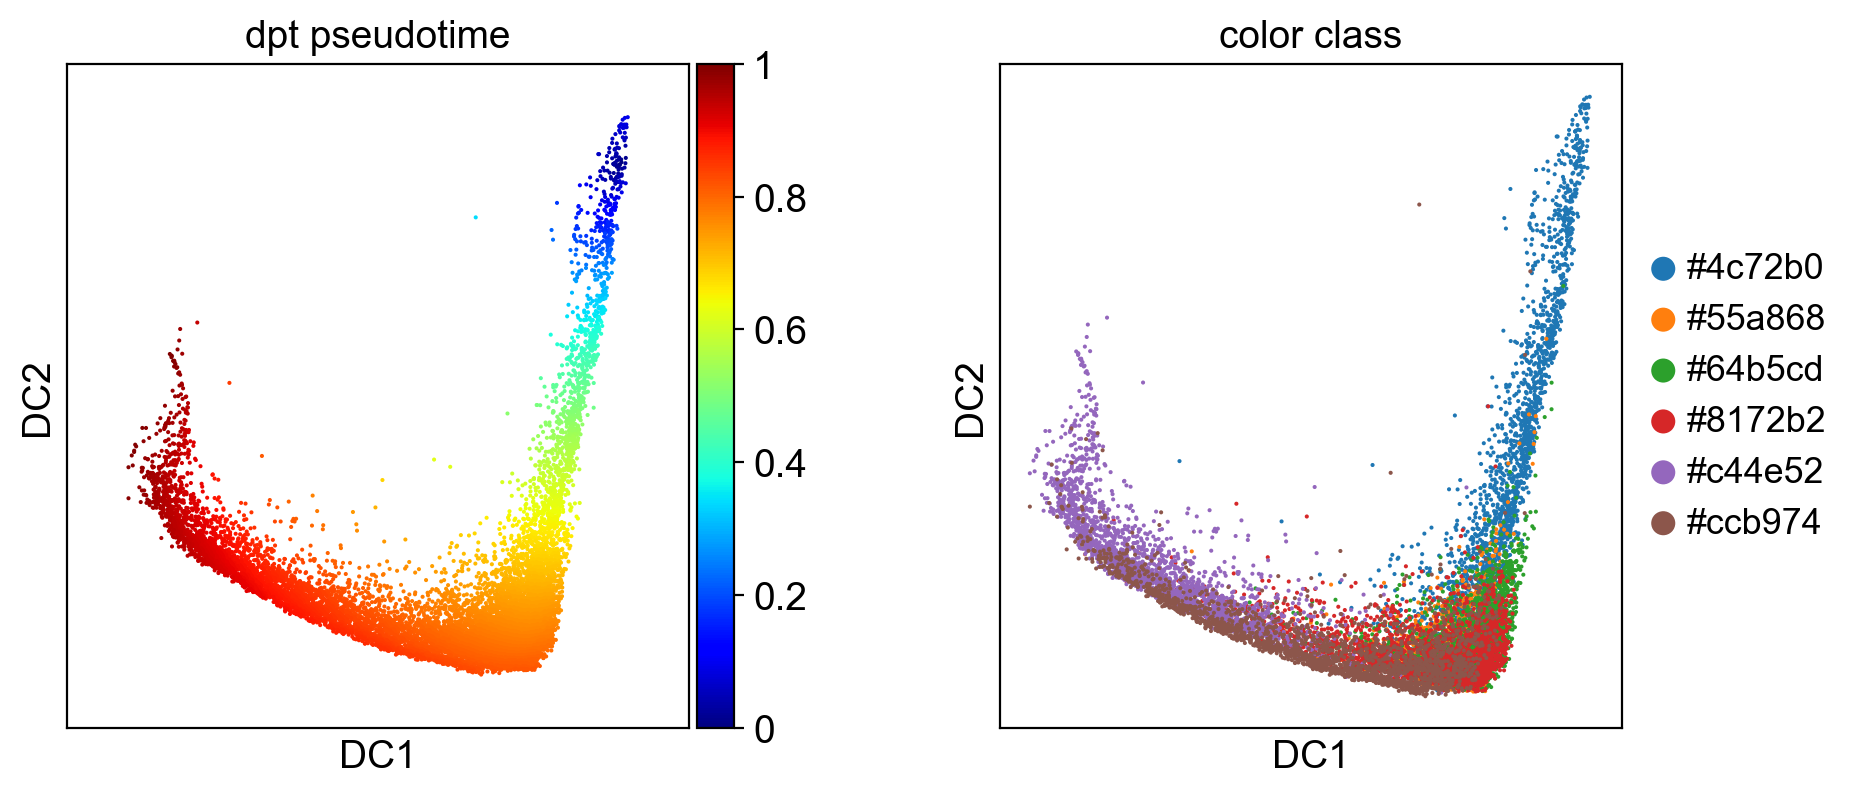

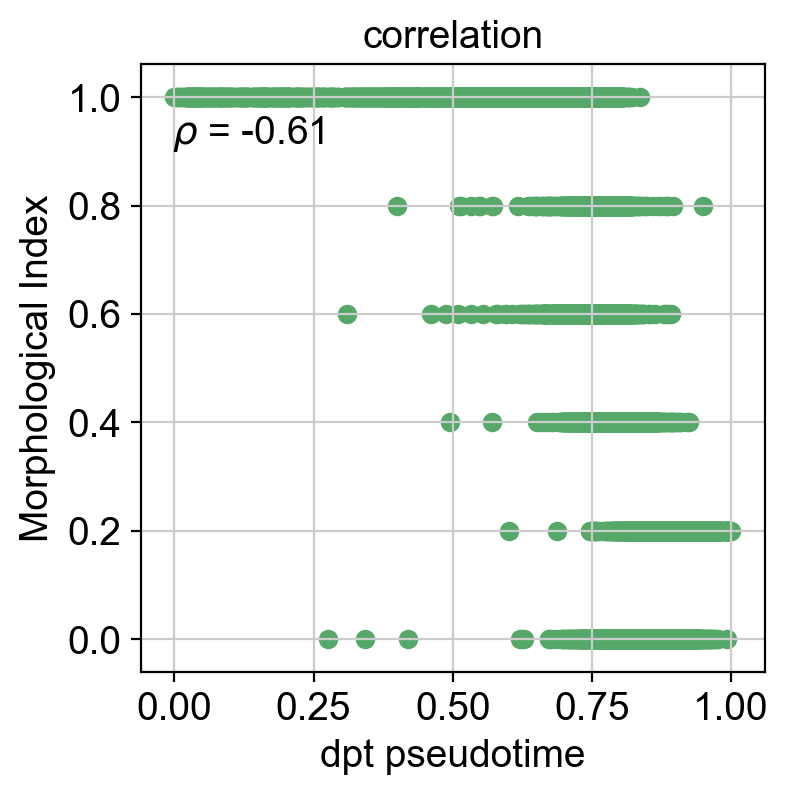

In [21]:
def plot_correlation(adata, title):
    plt.clf()
    rho, pvalue = scipy.stats.pearsonr(adata.smp['dpt_pseudotime'], adata.smp['MorphoIndex'])
    #plt.figure(figsize=(12, 8))
    plt.scatter(adata.smp['dpt_pseudotime'], adata.smp['MorphoIndex'], c='#55a868')
    plt.xlabel('dpt pseudotime')
    plt.ylabel('Morphological Index')

#    plt.ylim(0, 1)
    plt.yticks(numpy.arange(0, 1.2, 0.2))
    
    plt.title(title)
    plt.text(0.05, 0.87, r'$\rho$ = {:.2}'.format(rho), transform=plt.axes().transAxes)
    plt.grid(True)
    #plt.savefig(os.path.join(output_subdirectory,str('DPT_correl.png')), dpi = 300)
    plt.show()    


# axs = sc.pl.tsne(adata, color=['dpt_pseudotime', 'color_class'], right_margin=0.5)
# plt.savefig(os.path.join(output_subdirectory_Morpho,str('DPT_morph'+test_bag+'_tsne.png')), dpi = 300)
axs = sc.pl.diffmap(adata, color=['dpt_pseudotime', 'color_class'], color_map='jet')
# plt.savefig(os.path.join(output_subdirectory_Morpho,str('DPT_morph'+test_bag+'_dm.png')), dpi = 300)
plot_correlation(adata, 'correlation')

# A better root

In [7]:
sc.tl.diffmap(adata)

In [8]:
# The 90-percentile of 2nd diffusion map components
idx = 0.90 * (len(adata.obsm.X_diffmap[:,1]) - 1)
idx = int(idx + 0.5)
print(idx)

12441


In [9]:
high_threshold_diffmap = adata.obsm.X_diffmap[:,1][numpy.argpartition(adata.obsm.X_diffmap[:,1], idx)[idx]]
print(high_threshold_diffmap)

0.009269702


In [18]:
#--- Pick a random Smooth Disc cell that has high 2nd diffusion map components --#
import random
a = adata.smp[((adata.obsm.X_diffmap[:,1] > high_threshold_diffmap) & (adata.smp['MorphoIndex'] == 1))].index.tolist()
b = [int(aa) for aa in a]

adata.var['xroot'] = adata.X[random.choice(b)]

# A simpler root

In [ ]:
#--- Assign the tip of Diffusion map  as root ---#
adata.var['xroot'] = adata.X[numpy.argmax(adata.obsm.X_diffmap[:,1])]